<a href="https://colab.research.google.com/github/mmmhdp/nn_labs/blob/main/lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import glob
import os
from torch import nn
from collections import defaultdict
import time
from IPython.display import clear_output

from torchsummary import summary
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_dir = "/content/drive/MyDrive/colab_notebooks/train_butterflies/train_split"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]

train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 3468
Изображений в val: 1487


In [3]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [4]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  50
Количество классов в val:  50
Количество классов одинаково:  True


In [5]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    dataset_size = len(dataset)

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=dataset_size)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

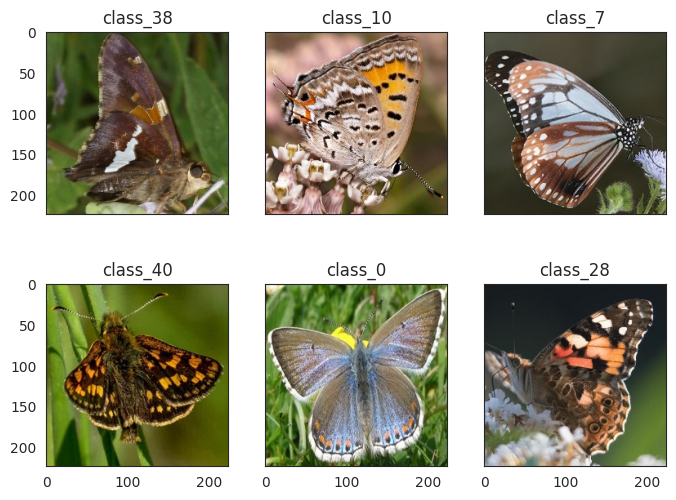

In [6]:
show_images(val_dataset)

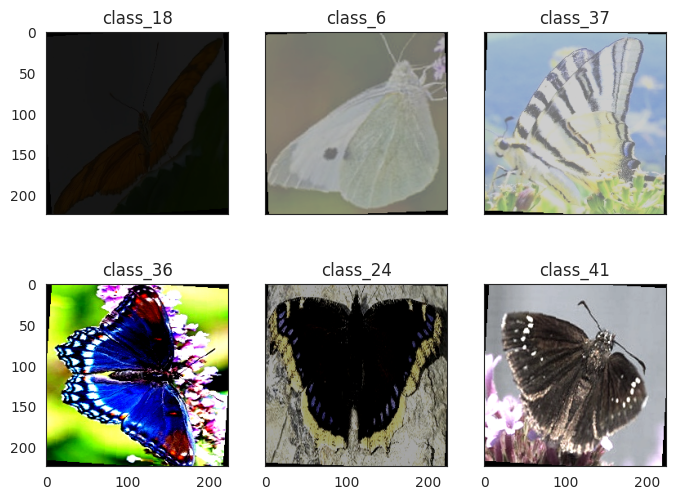

In [7]:
show_images(train_dataset)

In [8]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        print(epoch)
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        # plot_learning_curves(history)

    return model, history

In [11]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# Fine - tuning res18




In [12]:
from torchvision.models import resnet18

In [13]:
fine_tuning_model = nn.Sequential()


# заморозим все слои сети
for param in fine_tuning_model.parameters():
    param.requires_grad = False

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))


# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 50))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5
)

0
Epoch 1 of 5 took 341.733s
  training loss (in-iteration): 	3.712411
  validation loss (in-iteration): 	3.259026
  training accuracy: 			12.75 %
  validation accuracy: 			30.92 %
1
Epoch 2 of 5 took 41.902s
  training loss (in-iteration): 	2.765096
  validation loss (in-iteration): 	1.875149
  training accuracy: 			44.69 %
  validation accuracy: 			60.96 %
2
Epoch 3 of 5 took 41.397s
  training loss (in-iteration): 	1.594300
  validation loss (in-iteration): 	1.157420
  training accuracy: 			67.73 %
  validation accuracy: 			69.65 %
3
Epoch 4 of 5 took 41.439s
  training loss (in-iteration): 	0.952348
  validation loss (in-iteration): 	0.802529
  training accuracy: 			79.34 %
  validation accuracy: 			78.38 %
4
Epoch 5 of 5 took 41.512s
  training loss (in-iteration): 	0.645627
  validation loss (in-iteration): 	0.591365
  training accuracy: 			85.67 %
  validation accuracy: 			84.99 %


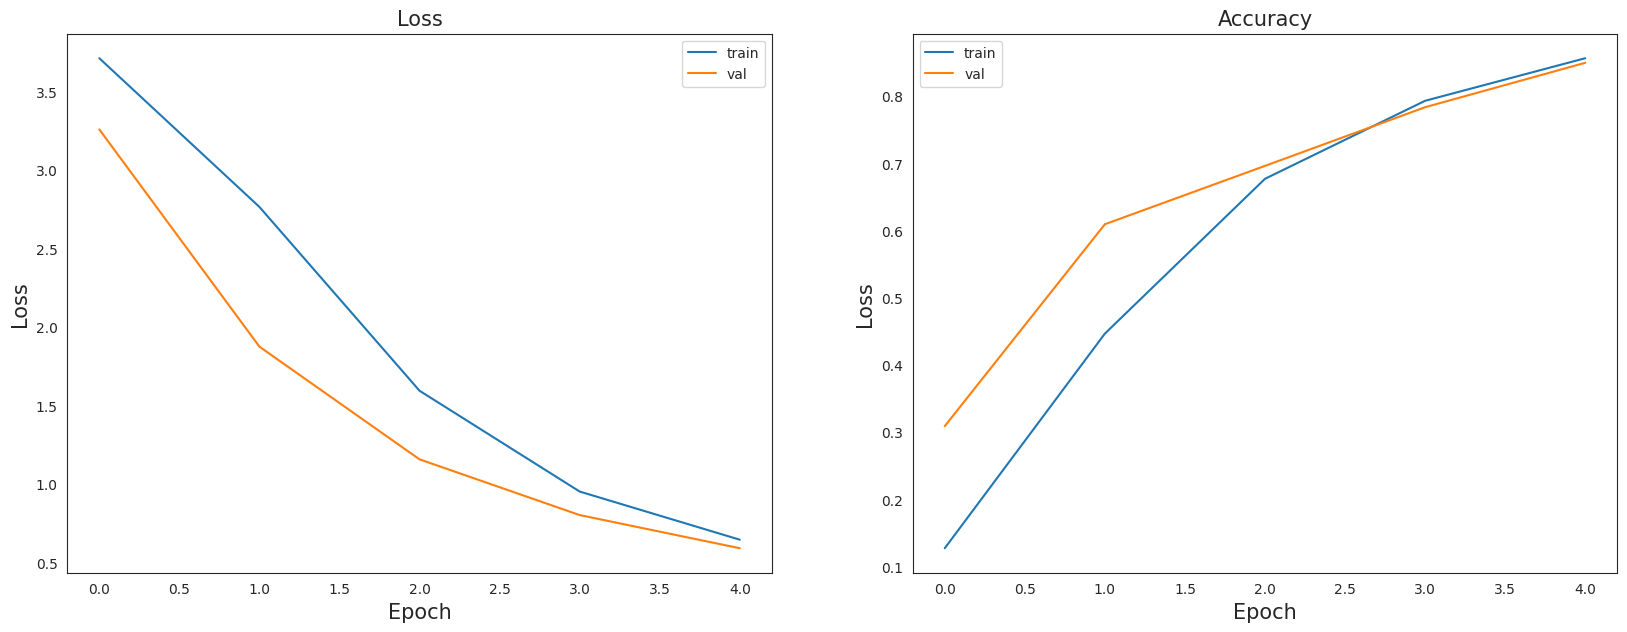

In [15]:
plot_learning_curves(history)

## Testing process

In [22]:
input_size = 224
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])


dummy_dataset = torchvision.datasets.ImageFolder(
    '/content/drive/MyDrive/colab_notebooks/train_butterflies/test_butterflies/',
    transform=transform)

In [23]:
dummy_dataset = torch.utils.data.DataLoader(
    dummy_dataset, batch_size=len(dummy_dataset), shuffle=False
)
print(dummy_dataset)


for X_batch, y_batch in dummy_dataset:
  X_batch = X_batch.to(device)
  logits = fine_tuning_model(X_batch)
  y_pred = logits.max(1)[1].detach().cpu().numpy()
  print(y_pred)

[ 6 35 32  1 26 13 42 46 30 48 31 46 23 18  3  2 36 40 25  8 43 43 23 47
 21 18 13 27 22 24 22 36  8 32 30 31 33 19 31  9  4 39 36  3  0 11 17 14
 30 27 15 23 42 24 14  4 21 28 34 29 12 22 41 10  5 14 10 21 19 24 19  4
 29 22 25 44  6 47 23  8 41 38 49 18 15 20 26 41  2  0 14 14  7 30 18 33
 30 39 46 28 27 27 17 13  2  1 33 47  6 13 32 41 48 23  4 38 35 18 44 44
 47 29 13 19 34 10 17 35 41 24  1 15 38 12  1 44 45 40 32 48 39 41 34 29
 28 15 26 25 40 21 11 38 19  5 19  9  4 24  3 33 36 17 21 26 46 12 34 45
 25 30 44 11 21 31 36 35 49 39  2  3 19 41 42 20 20  9  7 29 31 23 12 22
  0 14  3 32 45 10  5 35  7 41 46  2 20 33 41  6 32 26  6 11 34  8 45 45
 49 42 32 38 19 40 43 26 26 28 43 42 49 28 49 49 41 48  0 10  7 28 25 18
 48 15 36  8  7 43 12 47  0 19]


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.load_images()

    def load_images(self):
        for filename in os.listdir(self.data_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(self.data_dir, filename)
                self.images.append(image_path)
                self.labels.append(int(filename.split('.')[0]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


data_dir = '/content/drive/MyDrive/colab_notebooks/train_butterflies/test_butterflies/valid'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

custom_dataset = CustomImageDataset(data_dir, transform=transform)


dummy_dataloader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=False)


print(dummy_dataloader)


for X_batch, y_batch in dummy_dataloader:
    X_batch = X_batch.to(device)
    logits = fine_tuning_model(X_batch)
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    print(y_pred)


[48 14 43 18  1 35 10 24 48 44 11 33 27 14 24 15 20 14 18 49 48 20 31 18
 47 25  1 45  0 47  4 27 45 36  7 39  6 40 21  6 17 22 45 34 34 25 18 25
 30 28 41 23 13 13 23 43 33 14 23 43 39 26 33 29  7 13  2 25  4 30 41 23
 43 31 18 10  0 38 26 31 47 48 41 32 12 34 38 41 12 32  8 35 34 18 44 15
 30 19 32 26 41 36  0  1 12 28 29  9 49 11 23 14 10 32  6  9 34  5 22 36
 40 10 28 21  3 19 29  6 14 17 17 38 28 36 49 28  2 41 22  8 20  4 21  7
 24 31 30 46 35 26 47 32 42 36 44 21 15 19 49 28 44 26  1 35 19 22 21 42
 21  7  0 26 23 41 42 32 29 44 22 19 11 12 20 48  0 12 46 30 45 42 11 25
 41 26  8  8 19  5 27  4  3  3  2 29 24 33 35 36 45 42 41  3 15 41 27 39
 10 40  9  5 19 13 46 47 30 46 19 40 17 13 39 15 49  7 49  8 32  4 33 24
 38 31  6  2 43  3 19 38  2 46]


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.filenames_to_index = {}
        self.load_images()

    def load_images(self):
        for idx, filename in enumerate(os.listdir(self.data_dir)):
            if filename.endswith('.jpg'):
                image_path = os.path.join(self.data_dir, filename)
                self.images.append(image_path)
                self.labels.append(int(filename.split('.')[0]))
                self.filenames_to_index[filename] = idx

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)


        return image, label, os.path.basename(image_path), idx


data_dir = '/content/drive/MyDrive/colab_notebooks/train_butterflies/test_butterflies/valid'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


custom_dataset = CustomImageDataset(data_dir, transform=transform)


dummy_dataloader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=False)


print(dummy_dataloader)


for X_batch, y_batch, filenames, indices in dummy_dataloader:
    X_batch = X_batch.to(device)
    logits = fine_tuning_model(X_batch)
    y_pred = logits.max(1)[1].detach().cpu().numpy()


    filename_to_index_mapping = dict(zip(filenames, indices))
    predictions_with_filenames = [(filename, y_pred[filename_to_index_mapping[filename]]) for filename in filenames]

    print(predictions_with_filenames)


[('223.jpg', 48), ('157.jpg', 14), ('116.jpg', 43), ('9.jpg', 18), ('219.jpg', 1), ('202.jpg', 35), ('158.jpg', 10), ('24.jpg', 24), ('84.jpg', 48), ('166.jpg', 44), ('139.jpg', 11), ('184.jpg', 33), ('189.jpg', 27), ('18.jpg', 14), ('124.jpg', 24), ('229.jpg', 15), ('39.jpg', 20), ('180.jpg', 14), ('183.jpg', 18), ('81.jpg', 49), ('106.jpg', 48), ('175.jpg', 20), ('132.jpg', 31), ('11.jpg', 18), ('97.jpg', 47), ('165.jpg', 25), ('193.jpg', 1), ('50.jpg', 45), ('98.jpg', 0), ('206.jpg', 47), ('200.jpg', 4), ('142.jpg', 27), ('249.jpg', 45), ('30.jpg', 36), ('41.jpg', 7), ('135.jpg', 39), ('60.jpg', 6), ('221.jpg', 40), ('244.jpg', 21), ('0.jpg', 6), ('14.jpg', 17), ('125.jpg', 22), ('68.jpg', 45), ('248.jpg', 34), ('226.jpg', 34), ('89.jpg', 25), ('173.jpg', 18), ('114.jpg', 25), ('182.jpg', 30), ('15.jpg', 28), ('154.jpg', 41), ('144.jpg', 23), ('102.jpg', 13), ('121.jpg', 13), ('109.jpg', 23), ('78.jpg', 43), ('59.jpg', 33), ('140.jpg', 14), ('20.jpg', 23), ('117.jpg', 43), ('224.jpg

In [28]:
import pandas as pd
submission_df = pd.DataFrame({
    'index': range(len(y_pred)),
    'label': y_pred
})

In [107]:
import pandas as pd
predictions_dict = {filename: label for filename, label in predictions_with_filenames}

submission_df = pd.DataFrame(predictions_dict.items(), columns=['filename', 'label'])
submission_df['index'] = submission_df.index
submission_df = submission_df[['index', 'label']]
submission_df['label'] = submission_df['label'].apply(lambda x: x + 1)

print(submission_df)

     index  label
0        0     49
1        1     15
2        2     44
3        3     19
4        4      2
..     ...    ...
245    245      4
246    246     20
247    247     39
248    248      3
249    249     47

[250 rows x 2 columns]


In [106]:
submission_df['label'].min()
submission_df.to_csv('butterfly.csv', index=False)

cur_cl = train_dataset.classes

wrong_csv = pd.read_csv('/content/butterfly.csv')

idxs = [f"{i}" for i in range(250)]
idxs.sort()

right_df = pd.DataFrame({
    'index': idxs,
    'label': wrong_csv['label']
})


right_df['label'] = right_df['label'].map(
        lambda x:
            int( cur_cl[x].split('_')[1] if x != 50 else 49 )
    )

# right_df['label'] = right_df['label'].map(
#         lambda x: x+1)

right_df
cur_cl
right_df.to_csv('fixed.csv', header=["index","label"], index=False)